## Week 4, Lab 2: Predicting Chronic Kidney Disease in Patients
> Author: Matt Brems

We can sketch out the data science process as follows:
1. Define the problem.
2. Obtain the data.
3. Explore the data.
4. Model the data.
5. Evaluate the model.
6. Answer the problem.

In this lab, we're going to focus on steps exploring data, building models and evaluating the models we build.

There are three links you may find important:
- [A set of chronic kidney disease (CKD) data and other biological factors](./chronic_kidney_disease_full.csv).
- [The CKD data dictionary](./chronic_kidney_disease_header.txt).
- [An article comparing the use of k-nearest neighbors and support vector machines on predicting CKD](./chronic_kidney_disease.pdf).

## Step 1: Define the problem.

Suppose you're working for Mayo Clinic, widely recognized to be the top hospital in the United States. In your work, you've overheard nurses and doctors discuss test results, then arrive at a conclusion as to whether or not someone has developed a particular disease or condition. For example, you might overhear something like:

> **Nurse**: Male 57 year-old patient presents with severe chest pain. FDP _(short for fibrin degradation product)_ was elevated at 13. We did an echo _(echocardiogram)_ and it was inconclusive.

> **Doctor**: What was his interarm BP? _(blood pressure)_

> **Nurse**: Systolic was 140 on the right; 110 on the left.

> **Doctor**: Dammit, it's an aortic dissection! Get to the OR _(operating room)_ now!

> _(intense music playing)_

In this fictitious but [Shonda Rhimes-esque](https://en.wikipedia.org/wiki/Shonda_Rhimes#Grey's_Anatomy,_Private_Practice,_Scandal_and_other_projects_with_ABC) scenario, you might imagine the doctor going through a series of steps like a [flowchart](https://en.wikipedia.org/wiki/Flowchart), or a series of if-this-then-that steps to diagnose a patient. The first steps made the doctor ask what the interarm blood pressure was. Because interarm blood pressure took on the values it took on, the doctor diagnosed the patient with an aortic dissection.

Your goal, as a research biostatistical data scientist at the nation's top hospital, is to develop a medical test that can improve upon our current diagnosis system for [chronic kidney disease (CKD)](https://www.mayoclinic.org/diseases-conditions/chronic-kidney-disease/symptoms-causes/syc-20354521).

**Real-world problem**: Develop a medical diagnosis test that is better than our current diagnosis system for CKD.

**Data science problem**: Develop a medical diagnosis test that reduces both the number of false positives and the number of false negatives.

In [1]:
# Imports
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

---

## Step 2: Obtain the data.

### 1. Read in the data.

In [2]:
df = pd.read_csv('./chronic_kidney_disease_full.csv')

In [3]:
df.head()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,121.0,...,44.0,7800.0,5.2,yes,yes,no,good,no,no,ckd
1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,NaN,...,38.0,6000.0,NaN,no,no,no,good,no,no,ckd
2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,423.0,...,31.0,7500.0,NaN,no,yes,no,poor,no,yes,ckd
3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,...,32.0,6700.0,3.9,yes,no,no,poor,yes,yes,ckd
4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,106.0,...,35.0,7300.0,4.6,no,no,no,good,no,no,ckd


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 25 columns):
age      391 non-null float64
bp       388 non-null float64
sg       353 non-null float64
al       354 non-null float64
su       351 non-null float64
rbc      248 non-null object
pc       335 non-null object
pcc      396 non-null object
ba       396 non-null object
bgr      356 non-null float64
bu       381 non-null float64
sc       383 non-null float64
sod      313 non-null float64
pot      312 non-null float64
hemo     348 non-null float64
pcv      329 non-null float64
wbcc     294 non-null float64
rbcc     269 non-null float64
htn      398 non-null object
dm       398 non-null object
cad      398 non-null object
appet    399 non-null object
pe       399 non-null object
ane      399 non-null object
class    400 non-null object
dtypes: float64(14), object(11)
memory usage: 78.2+ KB


In [5]:
# Replace rbc values with 0 for abnormal and 1 for normal
df['rbc'].value_counts()
rdict = {'normal': 1, 'abnormal': 0}
df.replace({'rbc': rdict}, inplace=True)

In [6]:
# Replace pc values with 0 for abnormal and 1 for normal
df['pc'].value_counts()
rdict = {'normal': 1, 'abnormal': 0}
df.replace({'pc': rdict}, inplace=True)

In [7]:
# Replace pcc values with 1 for present and 0 for not present
df['pcc'].value_counts()
rdict = {'notpresent': 0, 'present': 1}
df.replace({'pcc': rdict}, inplace=True)

In [8]:
# Replace ba values with 1 for present and 0 for not present
df['ba'].value_counts()
rdict = {'notpresent': 0, 'present': 1}
df.replace({'ba': rdict}, inplace=True)

In [9]:
# Replace htn values with 0 for no and 1 for yes
df['htn'].value_counts()
rdict = {'no': 0, 'yes': 1}
df.replace({'htn': rdict}, inplace=True)

In [10]:
# Replace dm values with 1 for yes and 0 for no
df['dm'].value_counts()
rdict = {'yes': 1, 'no': 0}
df.replace({'dm': rdict}, inplace=True)

In [11]:
# Replace cad values with 0 for no and 1 for yes
df['cad'].value_counts()
rdict = {'yes': 1, 'no': 0}
df.replace({'cad': rdict}, inplace=True)

In [12]:
# Replace appet values with 0 for poor and 1 for good
df['appet'].value_counts()
rdict = {'good': 1, 'poor': 0}
df.replace({'appet': rdict}, inplace=True)

In [13]:
# Replace pe values with 0 for no and 1 for yes
df['pe'].value_counts()
rdict = {'yes': 1, 'no': 0}
df.replace({'pe': rdict}, inplace=True)

In [14]:
# Replace ane values with 0 for no and 1 for yes
df['ane'].value_counts()
rdict = {'yes': 1, 'no': 0}
df.replace({'ane': rdict}, inplace=True)

In [15]:
# Replace class (target) values with 0 for notckd and 1 for ckd
df['class'].value_counts()
rdict = {'ckd': 1, 'notckd': 0}
df.replace({'class': rdict}, inplace=True)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 25 columns):
age      391 non-null float64
bp       388 non-null float64
sg       353 non-null float64
al       354 non-null float64
su       351 non-null float64
rbc      248 non-null float64
pc       335 non-null float64
pcc      396 non-null float64
ba       396 non-null float64
bgr      356 non-null float64
bu       381 non-null float64
sc       383 non-null float64
sod      313 non-null float64
pot      312 non-null float64
hemo     348 non-null float64
pcv      329 non-null float64
wbcc     294 non-null float64
rbcc     269 non-null float64
htn      398 non-null float64
dm       398 non-null float64
cad      398 non-null float64
appet    399 non-null float64
pe       399 non-null float64
ane      399 non-null float64
class    400 non-null int64
dtypes: float64(24), int64(1)
memory usage: 78.2 KB


In [17]:
df.isnull().sum()

age        9
bp        12
sg        47
al        46
su        49
rbc      152
pc        65
pcc        4
ba         4
bgr       44
bu        19
sc        17
sod       87
pot       88
hemo      52
pcv       71
wbcc     106
rbcc     131
htn        2
dm         2
cad        2
appet      1
pe         1
ane        1
class      0
dtype: int64

In [18]:
pd.set_option('display.max_columns', 25)
abs(df.corr()).sort_values(by='class', axis=1, ascending=False)[-1::]

,class,hemo,pcv,sg,rbcc,al,htn,dm,rbc,pc,bgr,appet,bu,sod,pe,su,ane,sc,bp,pcc,cad,wbcc,age,ba,pot
class,1.0,0.768919,0.741427,0.732163,0.699089,0.62709,0.58882,0.557444,0.555097,0.461812,0.419672,0.392645,0.380605,0.375674,0.37448,0.34407,0.324787,0.299969,0.294077,0.263226,0.235153,0.231919,0.227268,0.185345,0.084541


### 2. Check out the data dictionary. What are a few features or relationships you might be interested in checking out?

Answer: hemo, pcv, sg, rbcc, al, htn, dm, and rbc all have above .5 correlative value with respect to the target variable, making them prime candidates. Other than rbc and rbcc, the columns are missing less than 100 data points a piece which is nice considering how spotty the set is as a whole.

---

## Step 3: Explore the data.

### 3. How much of the data is missing from each column?

In [19]:
df.isnull().sum()

age        9
bp        12
sg        47
al        46
su        49
rbc      152
pc        65
pcc        4
ba         4
bgr       44
bu        19
sc        17
sod       87
pot       88
hemo      52
pcv       71
wbcc     106
rbcc     131
htn        2
dm         2
cad        2
appet      1
pe         1
ane        1
class      0
dtype: int64

### 4. Suppose that I dropped every row that contained at least one missing value. (In the context of analysis with missing data, we call this a "complete case analysis," because we keep only the complete cases!) How many rows would remain in our dataframe? What are at least two downsides to doing this?

> There's a good visual on slide 15 of [this deck](https://liberalarts.utexas.edu/prc/_files/cs/Missing-Data.pdf) that shows what a complete case analysis looks like if you're interested.

In [20]:
df.dropna().shape

(158, 25)

Answer: 158 rows would remain. Our model would have less data to train on making it that much less reliable.

### 5. Thinking critically about how our data were gathered, it's likely that these records were gathered by doctors and nurses. Brainstorm three potential areas (in addition to the missing data we've already discussed) where this data might be inaccurate or imprecise.

Answer: Some of these questions are subjective. How hungry are you? Meh. Oh he has no appetite. Others are on an arbitrary scale with no units. Doctors have notoriously poor handwriting

---

## Step 4: Model the data.

### 6. Suppose that I want to construct a model where no person who has CKD will ever be told that they do not have CKD. What (very simple) model can I create that will never tell a person with CKD that they do not have CKD?

> Hint: Don't think about `statsmodels` or `scikit-learn` here.

Answer: If you tell everyone they have CKD, nobody with CKD will be told that they do not have CKD

### 7. In problem 6, what common classification metric did we optimize for? Did we minimize false positives or negatives?

Answer: Sensitivity to minimize false negatives

### 8. Thinking ethically, what is at least one disadvantage to the model you described in problem 6?

Answer: False diagnoses will be rampant

### 9. Suppose that I want to construct a model where a person who does not have CKD will ever be told that they do have CKD. What (very simple) model can I create that will accomplish this?

Answer: Tell everyone that they do not have CKD

### 10. In problem 9, what common classification metric did we optimize for? Did we minimize false positives or negatives?

Answer: Specificity to minimize false positives

### 11. Thinking ethically, what is at least one disadvantage to the model you described in problem 9?

Answer: Diseased patients will suffer and die

### 12. Construct a logistic regression model in `sklearn` predicting class from the other variables. You may scale, select/drop, and engineer features as you wish - build a good model! Make sure, however, that you include at least one categorical/dummy feature and at least one quantitative feature.

> Hint: Remember to do a train/test split!

In [21]:
X = df[['hemo', 'pcv', 'sg', 'al', 'htn', 'dm', 'age', 'class']]

In [22]:
X.dropna(inplace=True)

/Users/Arya/anaconda3/envs/dsi/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [23]:
y = X['class']
X.drop(columns='class', inplace=True)

/Users/Arya/anaconda3/envs/dsi/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [24]:
print(X.shape)
print(y.shape)

(291, 7)
(291,)


In [25]:
lr = LogisticRegression()
ss = StandardScaler()

Xs = ss.fit_transform(X)

In [26]:
X_train, X_test, y_train, y_test = train_test_split(Xs, y)

In [27]:
model = lr.fit(X_train, y_train)

In [28]:
model.score(X_train, y_train)

0.9954128440366973

In [29]:
model.score(X_test, y_test)

0.958904109589041

In [30]:
model.coef_

array([[-1.27266048, -0.89237232, -2.19091611,  1.40030324,  0.74026408,
         1.25090406,  0.02609137]])

In [31]:
pd.DataFrame(list(zip(X.columns, model.coef_[0]))).sort_values(1, ascending=False)

,0,1
3,al,1.400303
5,dm,1.250904
4,htn,0.740264
6,age,0.026091
1,pcv,-0.892372
0,hemo,-1.272660
2,sg,-2.190916


---

## Step 5: Evaluate the model.

### 13. Based on your logistic regression model constructed in problem 12, interpret the coefficient of one of your quantitative features.

In [32]:
np.exp(-0.134874)

0.8738260068287553

For each unit change in age, a patient is .873826 times as likely to be ckd positive

### 14. Based on your logistic regression model constructed in problem 12, interpret the coefficient of one of your categorical/dummy features.

In [33]:
np.exp(0.782084)

2.1860231941200454

The presence of Diabetes Mellitus makes a patient 2.186 times more likely to be ckd positive

### 15. Despite being a relatively simple model, logistic regression is very widely used in the real world. Why do you think that's the case? Name at least two advantages to using logistic regression as a modeling technique.

Answer: Simple models tend to have more explanatory power than more complex models. The logistic model also has lower computational overhead when compared to other methods.

### 16. Does it make sense to generate a confusion matrix on our training data or our test data? Why? Generate it on the proper data.

> Hint: Once you've generated your predicted $y$ values and you have your observed $y$ values, then it will be easy to [generate a confusion matrix using sklearn](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html).

In [34]:
from sklearn.metrics import confusion_matrix

In [35]:
preds = lr.predict(Xs)
confusion_matrix(y, preds)

array([[137,   0],
       [  4, 150]])

4 False Negatives

### 17. In this hospital case, we want to predict CKD. Do we want to optimize for sensitivity, specificity, or something else? Why? (If you don't think there's one clear answer, that's okay! There rarely is. Be sure to defend your conclusion!)

Answer: Sensitivity to reduce false negatives and ensure people are diagnosed when they are sick

### 18. Write a function that will create an ROC curve for you, then plot the ROC curve.

Here's a strategy you might consider:
1. In order to even begin, you'll need some fit model. Use your logistic regression model from problem 12.
2. We want to look at all values of your "threshold" - that is, anything where .predict() gives you above your threshold falls in the "positive class," and anything that is below your threshold falls in the "negative class." Start the threshold at 0.
3. At this value of your threshold, calculate the sensitivity and specificity. Store these values.
4. Increment your threshold by some "step." Maybe set your step to be 0.01, or even smaller.
5. At this value of your threshold, calculate the sensitivity and specificity. Store these values.
6. Repeat steps 3 and 4 until you get to the threshold of 1.
7. Plot the values of sensitivity and 1 - specificity.

Text(0,0.5,'sensitivity')

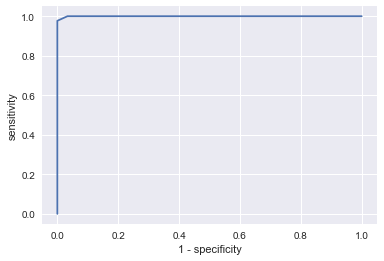

In [36]:
# Emma's function
thresholds = list(np.linspace(0,1,21))
sens = []
specs_inv = []
predictions = lr.predict_proba(X_test)
for threshold in thresholds:
    y_test_hat = []
    for obs in range(len(predictions)):
        if predictions[obs][1] < threshold:
            y_test_hat.append(0)
        else:
            y_test_hat.append(1)
    c_mat = confusion_matrix(y_test, y_test_hat)
    sens.append(c_mat[1,1] / (c_mat[1,1] + c_mat[1,0]))
    specs_inv.append(1 - (c_mat[0,0] / (c_mat[0,0] + c_mat[0,1])))
        
plt.plot(specs_inv, sens)
plt.xlabel('1 - specificity')
plt.ylabel('sensitivity')

### 19. Suppose you're speaking with the biostatistics lead at Mayo Clinic, who asks you "Why are unbalanced classes generally a problem? Are they a problem in this particular CKD analysis?" How would you respond?

Answer: Fudging data, even with a good idea of why it preserves the validity of the tests being run, always comes at some cost. In this case we did not have to do that.

### 20. Suppose you're speaking with a doctor at Mayo Clinic who, despite being very smart, doesn't know much about data science or statistics. How would you explain why unbalanced classes are generally a problem to this doctor?

Answer: I'd ask him if cloning would be an acceptable method of preserving a dying population

### 21. Let's create very unbalanced classes just for the sake of this example! Generate very unbalanced classes by [bootstrapping](http://stattrek.com/statistics/dictionary.aspx?definition=sampling_with_replacement) (a.k.a. random sampling with replacement) the majority class.

1. The majority class are those individuals with CKD.
2. Generate a random sample of size 1,600 of individuals who have CKD **with replacement**. (Consider setting a random seed for this part!)
3. Create a new dataframe with the original data plus this random sample of data.
4. Now we should have a dataset with 2,000 observations, of which only 150 (7.5%) are non-CKD individuals.

In [55]:
samples = np.random.choice(y, size=1600, replace=True)

In [56]:
ckd_extra = pd.concat([df.loc[samples, :], X],axis=0)

In [57]:
ckd_features = ckd_extra[['hemo', 'pcv', 'sg', 'al', 'htn', 'dm', 'age', 'class']]

In [58]:
X = ckd_features.drop(columns='class')
y = ckd_features['class'].apply(lambda x: 1 if x == 'ckd' else 0)

X.shape, y.shape

((1891, 7), (1891,))

### 22. Build a logistic regression model on the unbalanced class data and evaluate its performance using whatever method(s) you see fit. How would you describe the impact of unbalanced classes on logistic regression as a classifier?

In [62]:
lr = LogisticRegression()
ss = StandardScaler()

Xs = ss.fit_transform(X)

In [63]:
X_train, X_test, y_train, y_test = train_test_split(Xs, y)

In [64]:
X_train.shape, y_train.shape

((1418, 7), (1418,))

In [65]:
# I don't understand what is wrong here but I can't seem to resolve it
model = lr.fit(X_train, y_train)

ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 0

---

## Step 6: Answer the problem.

At this step, you would generally answer the problem! In this situation, you would likely present your model to doctors or administrators at the hospital and show how your model results in reduced false positives/false negatives. Next steps would be to find a way to roll this model and its conclusions out across the hospital so that the outcomes of patients with CKD (and without CKD!) can be improved!